# LOCALIZATION SYSTEMS – Satellite Navigation Systems (Practice 2)

In this practice, we will focus on the acquisition stage of a GNSS receiver, which correlates a local generated replica of the PRN sequence in order to identify the satellite-in-views and obtain an initial delay.

As usual, first we need to import some Python modules as well as define several methods that will be used throughout the practice. 

The following methods deal with the Pseudo Random Noise (PRN) codes that are generated by Satellite Navigation Systems based on Code Division Multiplex Access (CDMA) such as GPS, Galileo or Beidou. The PRN code generation is based on **Gold code shift registers**, which provide critical auto-correlation and cross-correlation properties, as will be shown in the practice. The following diagram (extracted from the [following link](https://es.mathworks.com/help/comm/ug/generate-gps-coarse-acquisition-codes.html)) may help you visualize how shift registers work.

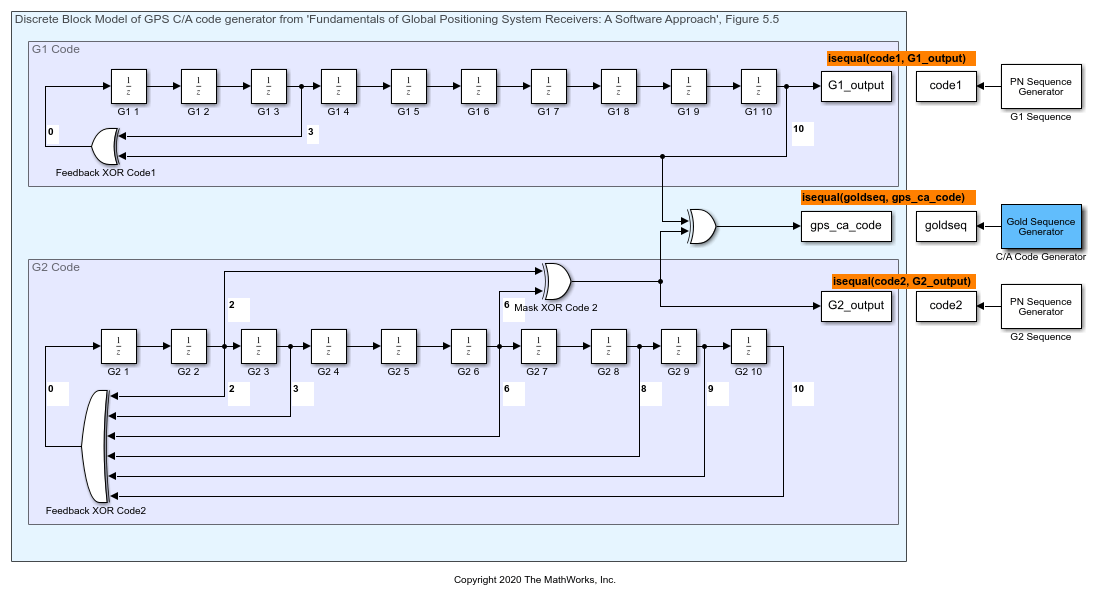

Please spend some time getting used to the code and try to understand what is being done in each method.

<strong>
Exercise 0

Have a look at the code provided and briefly explain the basic functionality of the methods provided
</strong>

In [ ]:
from functools import reduce
from typing import List, Tuple
import random

import matplotlib.pyplot as plt

# Phase selectors for the G2 generating polynomial, as defined in Table 3-Ia 
# of the GPS Interface Control Document (IS-GPS-200H document)
G2_CODE_PHASE_SELECTOR = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

def xor(x:int, y:int) -> int:
    """ Exclusive OR operation """
    return x^y

def get_register_values(register:List[int], taps:List[int]):
    return [register[i-1] for i in taps]

def shift_register(register:List[int], feedback_taps:List[int], shift_phase_selector:List[int]) -> Tuple[int, List[int]]:
    """GPS Shift Register
    
    :param list feedback_taps: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register and the shifted register:
    """

    # Compute register output
    register_values = get_register_values(register, shift_phase_selector)
    register_output = reduce(xor, register_values) if len(shift_phase_selector) > 1 else register_values[0]

    # Get the values in the taps specified by the user
    register_values = get_register_values(register, feedback_taps)

    # Perform XOR operations accross all elements of the output register  
    feedback_value = reduce(xor, register_values)

    # Shift register and feedback (prepend) the tap result
    shifted_register = [feedback_value]+register[0:-1]

    return register_output, shifted_register

def build_gps_ca_code(prn_id:int, num_chips=1023) -> List[int]:
    """Build the CA code (PRN) for a given satellite ID"""
    
    # init registers
    G1 = [1] * 10
    G2 = [1] * 10

    shift_phase_selector = G2_CODE_PHASE_SELECTOR[prn_id]

    # Output CA code
    ca = []
    
    # create sequence
    for i in range(num_chips):
        g1, G1 = shift_register(G1, [3,10], [10])
        g2, G2 = shift_register(G2, [2,3,6,8,9,10], shift_phase_selector)
        
        ca_value = xor(g1, g2)
        ca.append(ca_value)

    return ca

def delay_code(code, delay_chips):
  
    return code[delay_chips:] + code[0:delay_chips]

def cross_correlation(code_a, code_b):

    scale_value = lambda x : 2 * x - 1

    correlation = sum([scale_value(v_a) * scale_value(v_b) for v_a, v_b in zip(code_a, code_b)])

    return correlation

def compute_correlation_function(code_a, code_b):

    correlation = []

    for delay in range(1023):
      delayed_code = delay_code(code_b, delay)
      correlation_value = cross_correlation(code_a, delayed_code)
      correlation.append(correlation_value)

    return correlation



## Gold codes and its properties


First, we need to generate the local replicas of the PRN codes at the receiver using the `build_gps_ca_code`. Pick a PRN number comprised between 1 and 32 and plot the resulting code

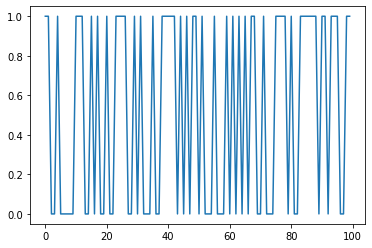

In [ ]:
# Select a PNR value
PRN_ID = <select_prn_code>

# Build the C/A code for this PRN
ca_code = build_gps_ca_code(PRN_ID)

# Plot the first 100 chips of the C/A code
plt.plot(ca_code[0:100])

**Exercise 1** 

**The chips are either 0s or 1s, but to compute the autocorrelation and cross correlation function we need to scale them between -1 and 1 (i.e. `0` -> `-1` and `1` -> `+1`). Perform the scale of the `ca_code` and plot the result**

Tip: use the following code to get the scale function as well as a quick tutorial on how to build a `list` using [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [3]:
# Use the scale function to convert from 0,1 to -1,1
def scale(value):
  return 2 * value - 1

# Usage of "list comprehensions"
a = [1, 2, 3, 4]

def f(x):
  return 2*x

[f(v) for v in a]

[2, 4, 6, 8]

Now we have the tools to generate the local PRN replicas for all GPS satellites for the C/A signal present in the L1 frequency. Once generated, we need to compare them with the received signal in order to determine

1. which satellites are present
2. which is the delay for the satellites-in-view.

To do this, GNSS receivers apply the [*cross-correlation* operation](https://en.wikipedia.org/wiki/Cross-correlation), which for a given 2 functions $f$ and $g$, is defined for all possible relative delays $\tau$ as:

$(f \star g)(\tau) = \int_{-\infty}^\infty \bar{f(t)} \cdot g(t+\tau)dt$

The intuition of this equation is that the *cross-correlation* measures the similarity between two functions. Note that the *autocorrelation* measures the similarity of a signal with itself. The main correlation properties of the Gold codes are as follows:
- The autocorrelation of a Gold code (i.e. correlation of a Gold code with itself) will yield maximum value when the delay between the codes is 0 and close to 0 for any other different delays
- The cross-correlation of two Gold codes will be close to 0

<strong>
Exercise 2

Compute the autocorrelation function of a PRN Code of your choice and plot the result. Answer the following questions:

- What is the peak value of the autocorrelation function?
- What are the secondary values of the autocorrelation function?
- Do the autocorrelation function values of another PRN code differ from the ones you computed?

</strong>

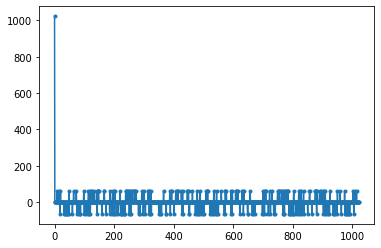

In [ ]:
PRN_ID = <select_prn_code>

ca_code = build_gps_ca_code(PRN_ID)
correlation = compute_correlation_function(ca_code, ca_code)
plt.plot(correlation, '.-')

**Tip: you can use a `set` container, whose all its elements are unique**

In [ ]:
# Example of code to obtain the unique values of an array
array = [1, 1, 2, 2, 2, 2, 3, 3, 3, 4]
set(array)

{1, 2, 3, 4}

<strong>
Exercise 3

Compute the cross correlation function of two PRN Code of your choice and plot the result. Answer the following questions:

- Is there a clear maximum as you observed in the autocorrelation function?
- What are the values of the crosscorrelation function? (use the same code you used to see the values of the autocorrelation function)
</strong>

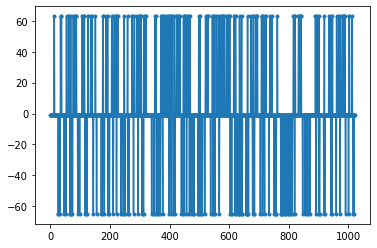

In [ ]:
PRN_ID_A = <select_prn_code>
PRN_ID_B = <select_another_prn_code>

ca_code_a = build_gps_ca_code(1)
ca_code_b = build_gps_ca_code(16)
correlation = compute_correlation_function(ca_code_a, ca_code_b)
plt.plot(correlation, '.-')

## Satellite acquisition

The satellite acquisition phase consists in processing the received GNSS signal and obtain the list of satellites that are present in it. To do that let's generate a test GNSS signal (`signal`) that will consist in the superposition of 4 random codes at random delays

In [ ]:
NUM_PRN = 4
prn_satellites = random.sample(list(range(1,32)), k=NUM_PRN)
delays = random.sample(list(range(1023)), k=NUM_PRN)

signal = None

for prn_id, delay in zip(prn_satellites, delays):
  code = build_gps_ca_code(prn_id)
  delayed_code = delay_code(code, delay)

  if not signal:
      signal = delayed_code
  else:
      signal = [a + b for a, b in zip(signal, delayed_code)]

On the acquisition phase, the receiver loops for all possible PRN candidates as well as potential delays to identify which satellites need to be tracked (in the subsequent **tracking** phase). Let's compute and plot the correlation between the `signal` and all codes generated by all possible PRN codes (32) as well as delays (1023).

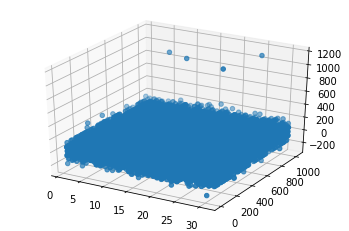

In [ ]:
xs = []
ys = []
zs = []

for prn in list(range(1, 32)):
  prn_code = build_gps_ca_code(prn)
  for delay in list(range(1023)):
    delayed_code = delay_code(prn_code, delay)
    correlation = cross_correlation(signal, delayed_code)

    xs.append(prn)
    ys.append(delay)
    zs.append(correlation)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)


<strong>
Exercise 4

What do you see in the plot? Can you identify which are the satellites and delays of the GPS satellites that are present in the signal? Double check your results by comparing the values you obtain with the contents of `prn_satellites` and `delays` variable generated before.

Tip: you can use Numpy `where` function to get the indices of those values that are larger than a certain value (see example below)
</strong>

In [ ]:
# Example of Numpy where function usage
import numpy as np

xs_test = [2, 2, 2, 4, 4, 4, 5, 5, 5]
ys_test = [1, 2, 3, 1, 2, 3, 1, 2, 3]
zs_test = [0, 0, 2, 3, 4, 2, 3, 2, 4]

indices = np.where(np.array(zs_test) >= 4)[0]

for index in indices:
  print(f'x {xs_test[index]} y {ys_test[index]}')

x 4 y 2
x 5 y 3


## References

- Python code explaining the generation of GPS C/A codes [The GPS PRN (Gold Codes), natronics](https://natronics.github.io/blag/2014/gps-prn/)
- GPS Interface Control Document [IS-GPS-200M](https://www.gps.gov/technical/icwg/IS-GPS-200M.pdf)